# Analysing historical droughts in Loire basin at Blois station

This notebook is used to analyse historical discharge data to analyse periods of drought. The HBV model is used and an algorithm which calculates the amount of droughts and severity of the drought.

### 1. Importing general python modules

In [437]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd

#niceties
from rich import print

In [438]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [439]:
# import drought analyser function
%run Drought_analyser.ipynb

### 2. Defining experiment data and paths 

In [440]:
# name of the catchment
basin_name = "FR003882"

# defining dates for calibration
experiment_start_date = "1990-01-01"
experiment_end_date = "2019-12-31"

# defining path for catchment shape file
station_shp = Path.home() / "BEP-Loire" / "book" / "model_loire" / "estreams_cb_FR003882.shp"

# defining destination path for ERA5 data
forcing_path_ERA5 = Path.home() / "forcing" / "loire_river" / "ERA5-5-12"
forcing_path_ERA5.mkdir(exist_ok=True)

# model HBV destination path
model_path_HBV = Path.home() / "tmp" / "HBV_model"

gdf = gpd.read_file("estreams_cb_FR003882.shp")
gdf = gdf.to_crs(epsg=2154)
gdf["area_km2"] = gdf.geometry.area / 1e6  
basin_area = gdf["area_km2"].sum()
print(basin_area)

38343.99370738107

### 3. Generating ERA5 forcings

In [441]:
# Option one: generate forcing:
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    directory= str(forcing_path_ERA5),
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=station_shp,
# )

# Get data from stored location
load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script" 
# Merged data
load_location = Path.home() / "forcing" / "loire_river" / "ERA5-90-19"
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

### 4. Defining historical data from eStreams

In [442]:
q_data = pd.read_csv("FR003882_streamflow_m3s.csv", index_col='date', parse_dates=True)[basin_name]
Q_obs = q_data[experiment_start_date:experiment_end_date]

### 5. Defining the parameters (from HBV_calibration.ipynb)

In [443]:
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]

# Good parameters for Qcrit = 60 m3/s
par_60 = [
    1.5145354171276855,
    0.42842089838706643,
    772.4812259147196,
    1.9621351322761909,
    0.032399644038749675,
    3.6033293703388503,
    0.05641243079972418,
    0.00877512417479108,
    0.20124202520262505
]

par_50 = [
    4.100177642474481,
    0.5564617209890717,
    56.284179880610886,
    3.074761223817448,
    0.21540407255522698,
    2.29412338923468,
    0.07308492910150667,
    0.00869850562817213,
    0.07375598323197557
]

# Good parameters for Qcrit = 50 m3/s

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0, 150, 0, 15, 0])

### 6. Running the model

In [444]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)
config_file, _ = model.setup(
    parameters=par_50, 
    initial_storage=s_0,
    cfg_dir = model_path_HBV,
)

In [445]:
model.initialize(config_file)

In [446]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [447]:
model.finalize()

### 7. Show results

404.0993695862287

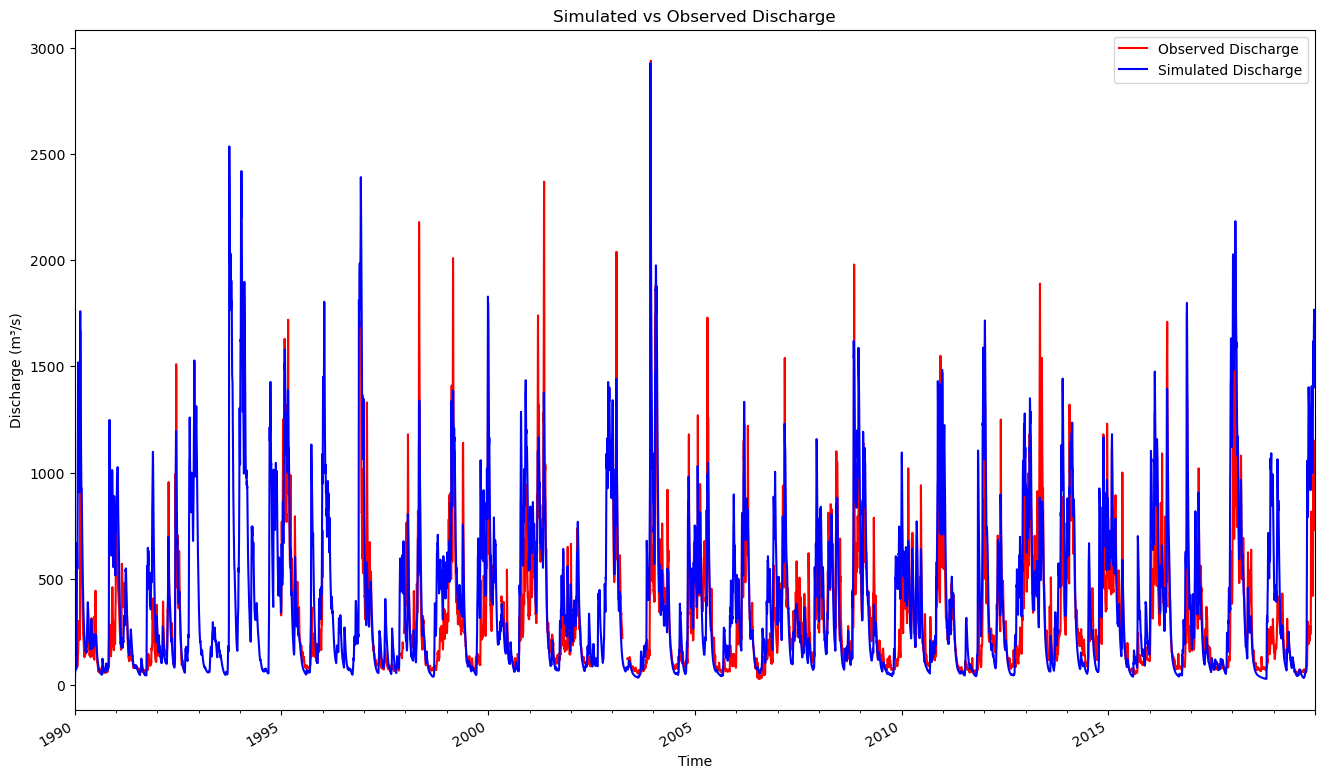

In [448]:
# convert model_output from mm/day to m3/s
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

def convert_Qsim_mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

# get the simulated discharges
Q_sim = convert_Qsim_mmday_to_m3s(model_output.values, basin_area)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")
print(Q_sim_pd.mean())

# get the right period
Q_sim_9719 = Q_sim_pd[experiment_start_date:"2014-12-31"]
Q_obs_9719 = Q_obs[experiment_start_date:"2014-12-31"]

# plot
plt.figure(figsize=(16, 10))
Q_obs.plot(label="Observed Discharge", color='red')
Q_sim_pd.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
#plt.ylim([0, 1000])
plt.legend()
plt.show()

### 8. Validation

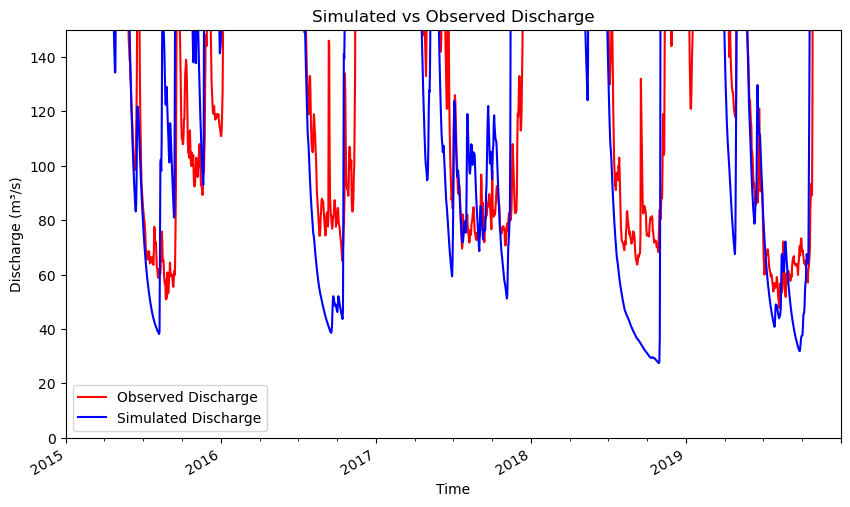

In [449]:
# get the right period
Q_sim_val = Q_sim_pd["2015-01-01":"2019-12-31"]
Q_obs_val = Q_obs["2015-01-01":"2019-12-31"]

# plot
plt.figure(figsize=(10, 6))
Q_obs_val.plot(label="Observed Discharge", color='red')
Q_sim_val.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
plt.ylim([0, 150])
plt.legend()
plt.show()

20

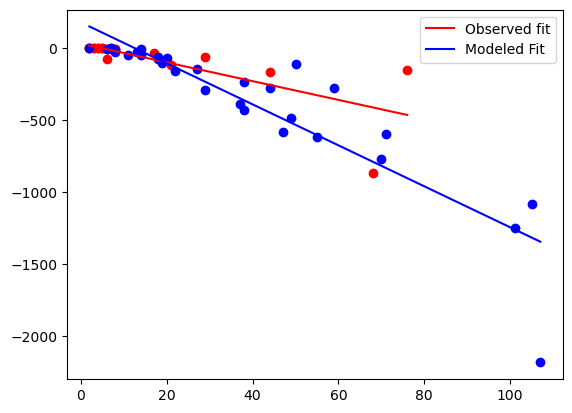

In [450]:
drought_obs = drought_analyser(Q_obs["1991-01-01":], basin_name, 60)
print(len(drought_obs["Drought Number"]))
drought_model = drought_analyser(Q_sim_pd["1991-01-01":], 'model output', 60)

xo, yo = drought_obs["Duration (days)"], drought_obs["Max Cumulative Deficit (m3/s)"]
xm, ym = drought_model["Duration (days)"], drought_model["Max Cumulative Deficit (m3/s)"]

coeffso = np.polyfit(xo, yo, 1)
poly_func_o = np.poly1d(coeffso)

coeffsm = np.polyfit(xm, ym, 1)
poly_func_m = np.poly1d(coeffsm)

x_smooth_o = np.linspace(xo.min(), xo.max(), 100)
y_smooth_o = poly_func_o(x_smooth_o)

x_smooth_m = np.linspace(xm.min(), xm.max(), 100)
y_smooth_m = poly_func_m(x_smooth_m)

# Plot the fitted curve
plt.plot(x_smooth_o, y_smooth_o, color="red", label="Observed fit")
plt.plot(x_smooth_m, y_smooth_m, color="blue", label="Modeled Fit")
plt.scatter(xo, yo, color="red")
plt.scatter(xm, ym, color="blue")
plt.legend()